In [1]:
import torch
from torch.utils.data import DataLoader
import os
import pandas as pd
from utils.dataset import PandasDataset, RGB2YHUTransform
from utils.models import EfficientNet
from utils.metrics import evaluation, format_metrics
import albumentations
import matplotlib.pyplot as plt

In [2]:
output_dimensions = 5
data_dir = '../../../dataset'
ROOT_DIR = "../.."
images_dir = os.path.join(data_dir, 'tiles')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
df_test = pd.read_csv("../../data/test.csv")
backbone_model = 'efficientnet-b0'
pretrained_model = {
    backbone_model: f'{ROOT_DIR}/efficientnet-b0-08094119.pth'
}

In [3]:
print("Cuda", device)

Cuda cuda


In [4]:
val_transform =albumentations.Compose([
    RGB2YHUTransform()
])

In [5]:
dataloader = DataLoader(
    PandasDataset(images_dir, df_test, transforms=val_transform),
    batch_size=2,
    shuffle=False,
)

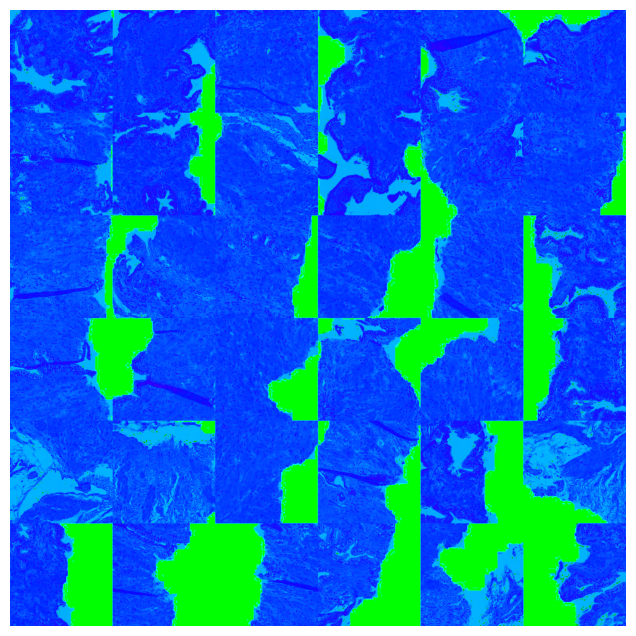

In [6]:
batch = next(iter(dataloader))
images, labels, _ = batch
plt.figure(figsize=(8, 8))
plt.imshow(torch.clamp(images[0], 0, 1).permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
# plt.title(f'Label: {labels[0].item()}')
plt.savefig("YHU.png", dpi=300)
plt.show()


In [7]:
model = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_dimensions,
    pre_trained_model=pretrained_model
)
model.to(device)
model.load_state_dict(
    torch.load(
        f"{ROOT_DIR}/models/with-noise-yhu.pth",
        weights_only=True
    )
)

response = evaluation(model, dataloader, device)
result = format_metrics(response[0])
print(result)

Loaded pretrained weights for efficientnet-b0


100%|██████████| 796/796 [09:53<00:00,  1.34it/s]


VAL_ACC      Mean: 55.06 | Std: 1.25 | 95% CI: [53.07, 57.16]
VAL_KAPPA    Mean: 0.81 | Std: 0.01 | 95% CI: [0.79, 0.83]
VAL_F1       Mean: 0.51 | Std: 0.01 | 95% CI: [0.49, 0.53]
VAL_RECALL   Mean: 0.50 | Std: 0.01 | 95% CI: [0.48, 0.53]
VAL_PRECISION Mean: 0.54 | Std: 0.01 | 95% CI: [0.51, 0.56]
